# Problèmes d'ajustement du modèle

## 18 : Répartition entre jeu d’entraînement et jeu de test

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

def load_california_housing_data():
    dataset = fetch_california_housing()
    X = pd.DataFrame(data=dataset.data, 
                     columns=dataset.feature_names)
    y = pd.Series(data=dataset.target, name="target")
    return X, y

X, y = load_california_housing_data()

print(X.shape, y.shape)

(20640, 8) (20640,)


In [3]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_jobs=-1)
knn_model.fit(X, y)

r2 = knn_model.score(X, y)

print(f"Valeur R2: {r2:.2f}")

Valeur R2: 0.47


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0)

print(f"Profil jeu Entraînement: {X_train.shape}")
print(f"Profil jeu Test: {X_test.shape}")

Profil jeu Entraînement: (16512, 8)
Profil jeu Test: (4128, 8)


In [5]:
from sklearn.metrics import mean_squared_error

knn_model.fit(X_train, y_train)

preds_train = knn_model.predict(X_train)
preds_test = knn_model.predict(X_test)

train_mse = mean_squared_error(y_true=y_train, y_pred=preds_train)
print(f"Erreur quadratique moyenne Entraînement: {train_mse:.5f}")

Erreur quadratique moyenne Entraînement: 0.73442


In [6]:
test_mse = mean_squared_error(y_true=y_test, 
                              y_pred=preds_test)
print(f"Erreur quadratique moyenne Test: {test_mse:.5f}")

Erreur quadratique moyenne Test: 1.11733


# Validation croisée

## Validation croisée sur k-plis 

In [7]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

cv = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(knn_model, X, y, cv=cv,
    scoring='neg_mean_squared_error', n_jobs=-1)

mean_mse = np.mean(np.abs(scores))
std_mse = np.std(scores)

print(f"Erreur quad. moy. de cv: {mean_mse:.5f} Ecart-type: {std_mse:.5f}")

Erreur quad. moy. de cv: 1.10818 Ecart-type: 0.02739


## Stratification des échantillons et données complexes

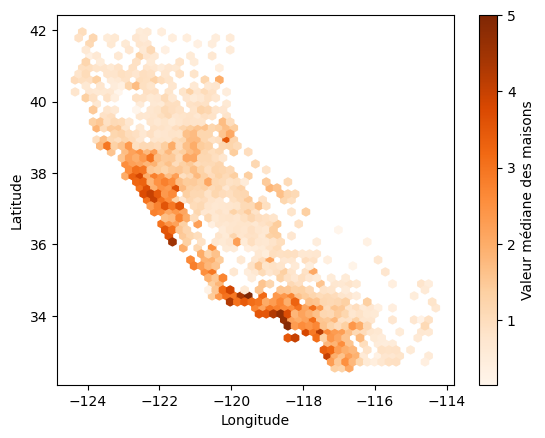

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

plt.hexbin(X.Longitude, X.Latitude, C=y, gridsize=50, 
           cmap='Oranges')
cb = plt.colorbar()
cb.set_label('Valeur médiane des maisons')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()


see: https://www.kaggle.com/competitions/playground-series-s3e1/discussion/376210
https://www.kaggle.com/code/dmitryuarov/ps-s3e1-coordinates-key-to-victory

In [9]:
from sklearn.cluster import KMeans

coordinates = X[["Latitude","Longitude"]]

clustering = KMeans(n_clusters=20, n_init=10, 
                    random_state=0)
clustering.fit(coordinates)

area = clustering.predict(coordinates)

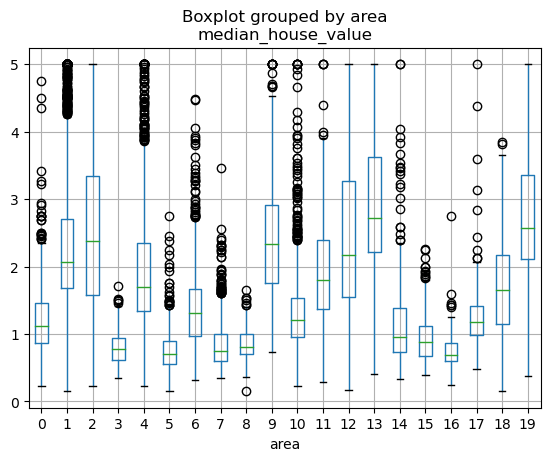

In [10]:
df_area = pd.DataFrame({"area": area, "median_house_value": y})
df_area.boxplot("median_house_value", by="area");

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

skf = StratifiedKFold(n_splits=10, shuffle=True, 
                      random_state=0)
scores = list()

for train_index, test_index in skf.split(X, area):
    X_train, X_test = X.iloc[train_index], \
        X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    scores.append(mean_squared_error(y_true=y_test,
                                     y_pred=y_pred))

print('%i plis Erreur quad. moy. de cv: %.5f Ecart-type: %.5f' % 
      (len(scores),np.mean(np.abs(scores)),
       np.std(scores)))

10 plis Erreur quad. moy. de cv: 1.10805 Ecart-type: 0.04569


# Stratégie de sélection des variables

In [12]:
df_area = pd.get_dummies(area, prefix="area")
df_X = pd.concat([X, df_area], axis=1)

## Sélection par mesures univariées

In [13]:
from sklearn.feature_selection import r_regression

correlations = r_regression(df_X, y)
for n, s in zip(df_X.columns, correlations):
    print(f"F-score: {s:+2.3f} pour la caractéristique {n}")

F-score: +0.688 pour la caractéristique MedInc
F-score: +0.106 pour la caractéristique HouseAge
F-score: +0.152 pour la caractéristique AveRooms
F-score: -0.047 pour la caractéristique AveBedrms
F-score: -0.025 pour la caractéristique Population
F-score: -0.024 pour la caractéristique AveOccup
F-score: -0.144 pour la caractéristique Latitude
F-score: -0.046 pour la caractéristique Longitude
F-score: -0.161 pour la caractéristique area_0
F-score: +0.092 pour la caractéristique area_1
F-score: +0.156 pour la caractéristique area_2
F-score: -0.113 pour la caractéristique area_3
F-score: -0.025 pour la caractéristique area_4
F-score: -0.165 pour la caractéristique area_5
F-score: -0.130 pour la caractéristique area_6
F-score: -0.224 pour la caractéristique area_7
F-score: -0.094 pour la caractéristique area_8
F-score: +0.046 pour la caractéristique area_9
F-score: -0.149 pour la caractéristique area_10
F-score: -0.012 pour la caractéristique area_11
F-score: +0.194 pour la caractéristique 

## Approche de sélection arrière ou avant

In [14]:
%%time
from sklearn.feature_selection \
    import SequentialFeatureSelector

selector = SequentialFeatureSelector(
    estimator=knn_model,
    direction='forward',
    cv=3,
    scoring='neg_mean_squared_error',
    n_features_to_select=14
)

selector.fit(df_X, y)
feature_mask = selector.support_
selected = [feature for feature, 
            support in zip(df_X.columns, 
                           feature_mask) if support]
print(f"Caractéristiques sélectionnées: {selected}")

Caractéristiques sélectionnées: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'area_5', 'area_6', 'area_7', 'area_8', 'area_9', 'area_11', 'area_15', 'area_17', 'area_19']
CPU times: total: 1min 8s
Wall time: 2min 10s


# Optimisation des hyperparamètres

## Recherche grid

In [15]:
knn_model = KNeighborsRegressor(n_jobs=1)

In [16]:
param_grid = {'n_neighbors': [1, 3, 5, 7, 10, 25, 50, 100],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan',
                         'cosine']}

In [17]:
from sklearn.model_selection import cross_val_score

score_metric = 'neg_mean_squared_error'
scores = cross_val_score(
    knn_model,
    X=df_X.loc[:, feature_mask],
    y=y,
    cv=10,
    scoring=score_metric,
    n_jobs=-1
)

baseline_score = np.mean(np.abs(scores))
print(f"Base avec paramètres par défaut: {baseline_score:.3f}")

Base avec paramètres par défaut: 0.533


### Attention ! Traitement long si cv=10 !

In [19]:
%%time
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring=score_metric,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    cv=10
)

search.fit(df_X.loc[:, feature_mask], y)

CPU times: total: 2.84 s
Wall time: 5min 43s


GridSearchCV(cv=2, estimator=KNeighborsRegressor(n_jobs=1), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'cosine'],
                         'n_neighbors': [1, 3, 5, 7, 10, 25, 50, 100],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [20]:
print(f"Meilleurs paramètres: {search.best_params_}")
print(f"Erreur quad. moy. CV des meilleurs param.: {abs(search.best_score_):.3f}")

Meilleurs paramètres: {'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}
Erreur quad. moy. CV des meilleurs param.: 0.499


In [21]:
print(search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_metric', 'param_n_neighbors', 'param_weights', 'params', 'split0_test_score', 'split1_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'mean_train_score', 'std_train_score'])


In [22]:
from sklearn.model_selection import validation_curve

tuned_model = KNeighborsRegressor(**search.best_params_, 
                                  n_jobs=-1)

train, test = validation_curve(tuned_model,
    df_X.loc[:, feature_mask], y,
    param_name='n_neighbors', param_range=range(10, 101, 10), 
    cv=3, scoring=score_metric, n_jobs=-1)

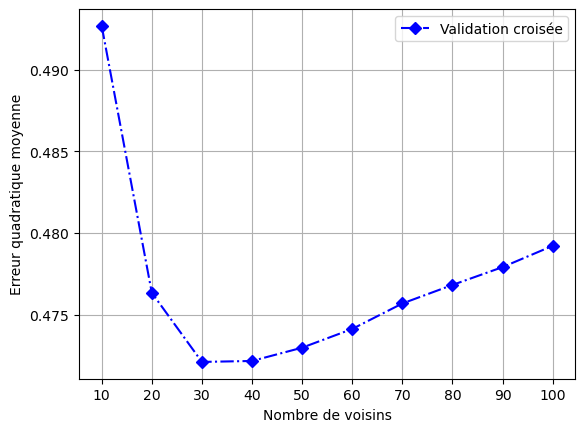

In [23]:
import matplotlib.pyplot as plt

mean_test = abs(np.mean(test, axis=1))

x_ticks_labels = range(10, 101, 10)
x_ticks_values = range(0, len(x_ticks_labels))
plt.plot(x_ticks_values, mean_test, 'bD-.', 
         label='Validation croisée')
plt.grid()
plt.xlabel('Nombre de voisins')
plt.xticks(x_ticks_values, x_ticks_labels)
plt.ylabel('Erreur quadratique moyenne')
plt.legend(loc='upper right', numpoints=1)
plt.show()

## Recherche aléatoire

In [24]:
%%time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

search = HalvingGridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring=score_metric,
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    cv=10,
    factor=2,
    max_resources='auto',
    aggressive_elimination=True,
    random_state=42
)

search.fit(df_X.loc[:, feature_mask], y)
print(f"Meilleurs paramètres: {search.best_params_}")
best_score = abs(search.best_score_)
print(f"Erreur quad. moy. CV des meilleurs param.: "
      f"{best_score:.3f}")

Meilleurs paramètres: {'metric': 'cosine', 'n_neighbors': 50, 'weights': 'distance'}
Erreur quad. moy. CV des meilleurs param.: 0.474
CPU times: total: 10.4 s
Wall time: 9min 41s


In [25]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_neighbors': range(1, 100),
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'cosine']
             }

random_search = RandomizedSearchCV(
    estimator=knn_model, 
    param_distributions=param_grid, 
    n_iter=10,
    cv=10,
    scoring=score_metric,
    refit=True, 
    random_state=0,
    n_jobs=-1
)

random_search.fit(df_X.loc[:, feature_mask], y)
print(f"Meilleurs paramètres: {random_search.best_params_}")
best_score = abs(random_search.best_score_)
print(f"Erreur quad. moy. CV des meilleurs param.: "
      f"{best_score:.3f}")

Meilleurs paramètres: {'weights': 'distance', 'n_neighbors': 37, 'metric': 'cosine'}
Erreur quad. moy. CV des meilleurs param.: 0.473
CPU times: total: 2.33 s
Wall time: 46.2 s
